In [1]:
import numpy as np
import sklearn
import pandas as pd
import scipy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os
import shutil

In [2]:
directory = 'Rep 5'
if not os.path.exists(directory):
    # Create the directory
    os.makedirs(directory)
    
# Delete all files in the directory
for filename in os.listdir(directory):
    file_path = os.path.join(directory, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

In [3]:
test_data_file_path = 'Copy of Test values.xlsx'
test_data = pd.ExcelFile(test_data_file_path)

sheet_names = test_data.sheet_names
print(*sheet_names, sep='\n')

PumpV with Flow rate
Rubber tube flow testing
12V pump-3 fan - temp testing
7V pump-3 fan- temp testing
3.5V pump-3 fan- temp testing
3.5V pump-no fan-temp testing
12V pump-no fan-temp testing
7.5V pump-no fan- temp testing
12V pump - 1 fan - temp testin 
7V pump-1 fan-tem testing
3.5V-1 fan-temp testing
12V pump-2 fan-temp testing
7V pump-2 fan-temp testing
3.5V pump-2 fan-temp testing
12V pump-chiller-temp testing
7V pump-chiller-temp testing
3.5V pump-chiller-temp testing
Heater-Radiator-3.5V
Heater-Radiator-7V
Heater-Radiator-12V
Heater-Radiator-9.2V


In [4]:
# Identifiers
pump_0_id = 'pump-no'
pump_1_id = '-1'
pump_2_id = 'pump-2'
pump_3_id = 'pump-3'
pump_chill_id = 'pump-chiller'
heater_id = 'heater-radiator'

# Column names
time = 'Time (min)'
temp = 'Temperature (Celcius)'
flow_rate = 'Flow rate (l/min)'

# general labels
temp_plot = 'Temperature (Celsius)'
flow_rate_plot = 'Flow rate (L/min)'
voltage_plot = 'Voltage (V)'

In [5]:
def data_extraction(excel_sheet):
    data = pd.read_excel(test_data_file_path, excel_sheet, header=0, usecols=range(3))
    return data.ffill()

In [6]:
volts = [3.5, 7, 9.2 ,12]

def excel_sheet_spec(sheet_id):
    data = {}
    for volt in volts:
        for excel_sheet in sheet_names:
            if f'{volt}' in excel_sheet and sheet_id in excel_sheet.replace(" ", "").lower():
                data[volt] = data_extraction(excel_sheet)
    return data

In [7]:
heater_data = excel_sheet_spec(heater_id)

In [8]:
# save experimental values as, ambient temperature, final temperature and initial temperature

Tas = [30,30,30,30]
T0s = [32,31.5,31.5,31.5]
Tfs = []

for volt in volts:
    Tfs.append(heater_data[volt][temp].iloc[-1])

In [9]:
# sigmoid function
def sigmoid(t, k, L,a):
    return L/(1+np.exp(-k*(t+a)))

params = {}

def sigmoid_params(data):
    popt, _ = curve_fit(sigmoid, data[time], data[temp], method='trf',max_nfev=10000)
    return popt


for volt in volts:
    params[volt] = sigmoid_params(heater_data[volt])


# predict data for 3.5V experiment to be shown 
new_times = np.arange(8, 16)
predicted_temperatures = sigmoid(new_times, *params[3.5])
new_fr = heater_data[3.5][flow_rate].iloc[-1]

new_data = pd.DataFrame({time: new_times, 
                         temp: predicted_temperatures,
                         flow_rate: new_fr})


heater_data[3.5] = pd.concat([heater_data[3.5], new_data], ignore_index=True)

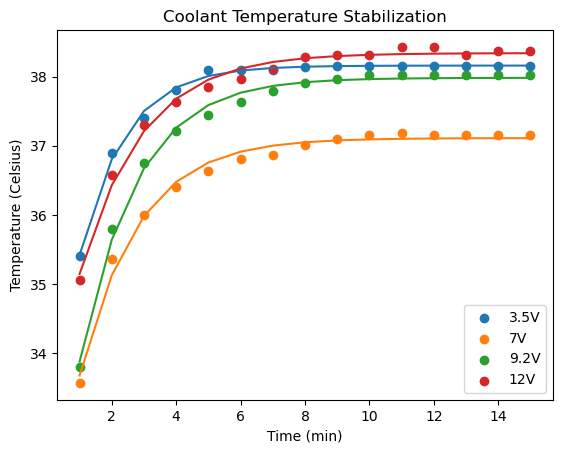

In [10]:
for volt in volts[:]:
    x = heater_data[volt][time]
    y = heater_data[volt][temp]
    y_pred = sigmoid(x, *params[volt])
    plt.scatter(x,y, label=f'{volt}V')
    plt.plot(x, y_pred)
plt.legend()
plt.xlabel(time)
plt.ylabel(temp_plot)
plt.title('Coolant Temperature Stabilization')
plt.savefig('Rep 5/experiment_coolant_temperature_stabilization.png')
plt.show()

# For this graph the lower the line the better performance of the system. 
# the best system was the 7V one, then the 9.2 volts, 3.5 volts and finally 12 volts. if we look at the steady state

In [11]:
# compare parameter L with Tf for each voltage, to see how well fitted is the curve

L_acc = {}

for volt, Tf in zip(volts, Tfs):
    L_acc[volt] = abs(Tf-params[volt][1])/Tf
    print(f'{L_acc[volt]:.4%}')

0.1578%
0.1039%
0.0964%
0.0767%


R²: 99.07%


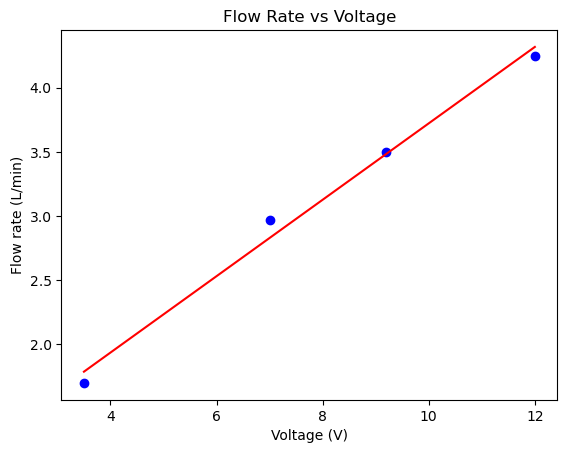

In [12]:
# plot flow rate in function of voltage
from sklearn.metrics import r2_score

def line(x, a, b):
    return a*x + b

frs = [1.7,2.97,3.5,4.25]

popt, _ = curve_fit(line, np.array(volts), frs)
frs_pred = line(np.array(volts), *popt)
r2 = r2_score(frs, frs_pred)

print(f'R\u00b2: {r2:.2%}')

plt.scatter(volts, frs, color='blue', label='Data')
plt.plot(volts, frs_pred, color='red', label='Fitted')
plt.xlabel(voltage_plot)
plt.ylabel(flow_rate_plot)
plt.title('Flow Rate vs Voltage')
plt.savefig('Rep 5/flow_rate_vs_voltage.png')
plt.show()

In [21]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plots_by_flow_rate(fr, volt, horizontal, vertical, sc_b, fig_name, title, n):
    # Parameters
    m_b = n * 70 / 1000  # Mass of battery (Kg)
    print(f'{n} Batteries mass:', m_b, 'Kg')
    c_b = sc_b  # Specific heat capacity of battery (KJ/Kg·C) 
    print('A Battery specific heat capacity:', c_b, 'KJ/Kg\u00b0C')
    vol_c = 1.27 / 1000  # volume of the coolant m3
    print('Coolant volume:', vol_c, 'm\u00b3')
    rho_c = 800  # density of the coolant Kg/m3
    print('Coolant density:', rho_c, 'Kg/m\u00b3')
    m_c = vol_c * rho_c  # Mass of coolant (Kg)
    print('Coolant mass:', m_c, 'Kg')
    c_c = 2.1  # Specific heat capacity of coolant (KJ/Kg·C)
    print('Coolant specific heat capacity:', c_c, 'KJ/Kg\u00b0C')
    A_contact = np.round(n * 0.75 * np.pi * 21.7 * 70.2 / (10**6), 6)  # Area of contact (m²)
    print(f'{n} Batteries contact area with the coolant:', A_contact, 'm\u00b2')
    dot_m_c = (rho_c * fr / 1000) / 60  # Mass flow rate of coolant (Kg/min)
    print(f'Coolant Mass Flow: {dot_m_c:.4f}', 'Kg/min')
    T_amb = 28  # Ambient temperature (°C)
    print('Room temperature:', T_amb, '\u00b0C')
    A_current = 4.2  # Current (Amperes)
    V_battery = 3.5  # Max Voltage capacity
    Q_in = n * A_current ** 2 * 10/1000  # Heat generated in the battery (KW)/(KJ/s)
    print(f'{n} Batteries heat released by internal resistance {Q_in:,.2f} KW')
    k = 0.05  # Cooling Coefficient of the Radiator

    # System of ODEs without the flow rate function (flow rate is constant)
    def system(t, y, h):
        T_b, T_c_in, T_c_out = y

        
        Q_out = h * A_contact * (T_b - T_c_out)
        dT_b_dt = (Q_in - Q_out) / (m_b * c_b)
        #dT_c_out_dt = (dot_m_c * c_c * (T_c_in - T_c_out) + Q_out) / (m_c * c_c) -k * (T_c_out - T_amb) * (m_c * c_c) * 60
        dT_c_out_dt = Q_out / (m_c * c_c) - k * (T_c_out - T_amb) * (m_c * c_c) * 60
        dT_c_in_dt = 0  # Assuming T_c_in is constant or can be set to zero if no change
    
        return [dT_b_dt, dT_c_in_dt, dT_c_out_dt]

    # Initial conditions
    T_b0 = T_amb  # Initial battery temperature (°C)
    T_c_in0 = T_amb  # Initial coolant temperature before cooling system (°C)
    T_c_out0 = T_amb  # Initial coolant temperature after cooling system (°C)
    y0 = [T_b0, T_c_in0, T_c_out0]
    
    # Time span for the simulation
    t_span = (0, 120)  # Simulate for 1 hour
    t_eval = np.linspace(*t_span, 1000)  # Time points at which to solve
    
    # Range of h values to simulate
    h_values = np.linspace(10, 200, 5)  # Example: 20 values from 10 to 100 W/m²·C
    
    # Store results for plotting
    T_b_results = np.zeros((len(h_values), len(t_eval)))
    T_c_out_results = np.zeros((len(h_values), len(t_eval)))

    
    # Loop over h values
    for i, h in enumerate(h_values):
        solution = solve_ivp(system, t_span, y0, t_eval=t_eval, args=(h,))
        T_b_results[i, :] = solution.y[0]  # Store the battery temperature for each h
        T_c_out_results[i, :] = solution.y[2]  # Store the coolant temperature after cooling system for each h

    T_low = np.round(T_b_results[-1][-1], 2)
    T_high = np.round(T_b_results[0][-1], 2)
    print()
    print(f'Highest Stable Achievable Temperature for the batteries: {T_high:.2f}\u00b0C')
    print(f'Lowest Stable Achievable Temperature for the batteries: {T_low:.2f}\u00b0C')
    print(f'with a room temperature of {T_amb:.2f}\u00b0C')
    
    # 3D Plotting
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create meshgrid for h values and time
    T, H = np.meshgrid(h_values, t_eval)
    x = np.linspace(np.min(T), np.max(T), 100)
    y = np.linspace(np.min(H), np.max(H), 100)
    y, x = np.meshgrid(x, y)
    z23 = np.full_like(x,23)
    z27 = np.full_like(x,27)
    
    # Plot the surface for batteries temperature 
    ax.plot_surface(H, T, T_b_results.T, color = 'springgreen', alpha=0.5,label='Batteries Avg. Temperature')

    # Plot the surface for coolant temperature after the cooling system
    ax.plot_surface(H, T, T_c_out_results.T, color='red', alpha=0.5, label='Coolant Temperature After Cooling System')

    ax.plot_surface(x, y, z27, alpha=1, rstride=100, cstride=100, color='blue', label = 'Max. Optimal Battery Temp: 27\u00b0C')

    #print(T_b_results[-1][-1])
    ax.set_xlabel(time)
    ax.set_ylabel(r'Heat Transfer Coeff. $\frac{W}{m^2\cdot ^0C}$')
    ax.set_zlabel(f'{temp_plot}')
    ax.set_title(title)
    ax.view_init(horizontal, vertical)
    ax.legend()
    #ax.set_zlim3d([25,35])
    #ax.invert_yaxis()
    ax.set_yticklabels([])
    plt.savefig(f'{fig_name}.png')
    plt.show()
    return T_low



120 Batteries mass: 8.4 Kg
A Battery specific heat capacity: 0.8 KJ/Kg°C
Coolant volume: 0.00127 m³
Coolant density: 800 Kg/m³
Coolant mass: 1.016 Kg
Coolant specific heat capacity: 2.1 KJ/Kg°C
120 Batteries contact area with the coolant: 0.430714 m²
Coolant Mass Flow: 0.0567 Kg/min
Room temperature: 28 °C
120 Batteries heat released by internal resistance 21.17 KW

Highest Stable Achievable Temperature for the batteries: 34.46°C
Lowest Stable Achievable Temperature for the batteries: 29.78°C
with a room temperature of 28.00°C


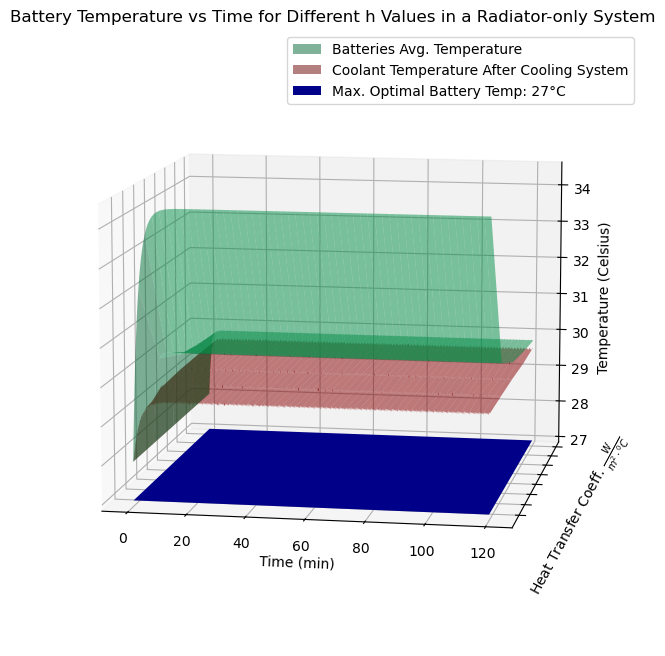

In [23]:
lowest_T_bs = []
n_bat = 120
for fr, volt in zip(frs[3:4], volts[3:4]):
    title = f'Battery Temperature vs Time for Different h Values in a Radiator-only System'
    fig_name = f'Rep 6/3d_radiator_sim_for_diff_heat_cap'
    T = plots_by_flow_rate(fr, volt, 10, -80, 0.8, fig_name, title,n_bat)
    lowest_T_bs.append(T)

# In this simulation the estable temperature is set by the heat transfer coefficient and the Flow-Rate.
# Higher values for h means that the battery looses more energy, in other words, the coolant can extract 
# more heat from the batteries. Also, the temperature gap between the coolant and the batteries decreases
# while h increases. 

# the effect of the flow rate on the system relapses on the coolant stable temperature, consequently the 
# stable temperature of the batteries is being affected. 


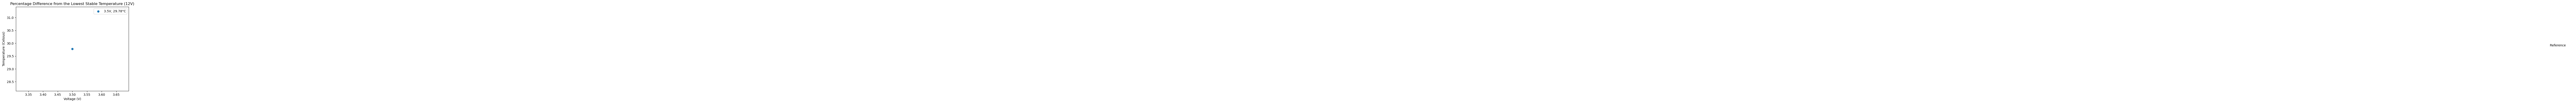

In [15]:
lowest_T_bs
frs

# assuming 25 degrees as the avg optimal value for the temperature
# to measure the performance of each system the equation that was used is
# Perf = (T_9.2 - T_12)/(T_12 - 25)
# Perf = (T_7 - T_12)/(T_12 - 25)
# Perf = (T_3.5 - T_12)/(T_12 - 25)
# T_12 - 25 is the reference because it is needed to see how much difference do 
# the other systems set-up are further from the lowest temperature.

p_diff_to_12_v = [(temperature-lowest_T_bs[-1])/(lowest_T_bs[-1]-25) for temperature in lowest_T_bs[:-1]]

for volt, lowest_T_b in zip(volts, lowest_T_bs):
    plt.scatter(volt, lowest_T_b, label=f'{volt}V, {lowest_T_b}\u00b0C')


for i, j, k in zip(volts[:-1], lowest_T_bs[:-1] ,p_diff_to_12_v):
    plt.text(i+.2,j-.05, f'{k:.2%}', ha='left')



plt.text(12,lowest_T_bs[-1]+.1,f'Reference        ', ha='center')
plt.legend()
plt.title('Percentage Difference from the Lowest Stable Temperature (12V)')
plt.xlabel(voltage_plot)
plt.ylabel(temp_plot)
plt.savefig('Rep 5/lowest_stable_temp_perc_diff.png')
plt.show()

120 Batteries mass: 8.4 Kg
A Battery specific heat capacity: 7.95 KJ/Kg°C
Coolant volume: 0.00127 m³
Coolant density: 800 Kg/m³
Coolant mass: 1.016 Kg
Coolant specific heat capacity: 2.1 KJ/Kg°C
120 Batteries contact area with the coolant: 0.430714 m²
Coolant Mass Flow: 0.0567 Kg/min
Room temperature: 28 °C
120 Batteries heat released by internal resistance 21.17 KW

Highest Stable Achievable Temperature for the batteries: 34.45°C
Lowest Stable Achievable Temperature for the batteries: 29.80°C
with a room temperature of 28.00°C


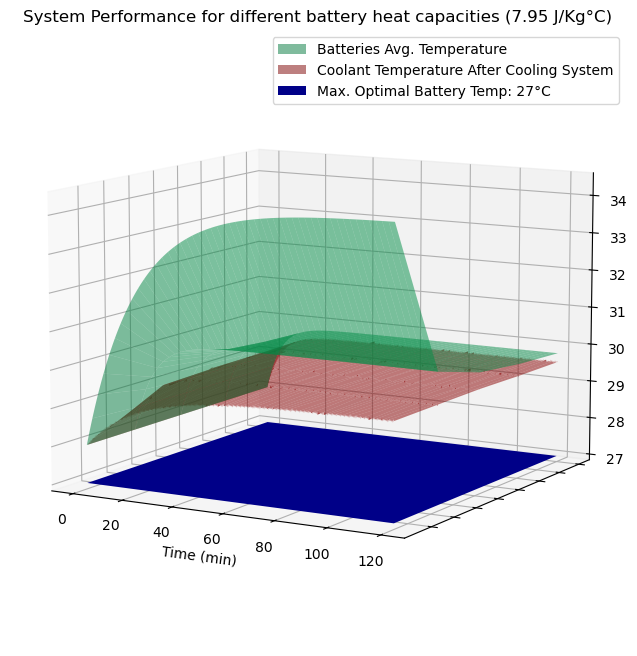

In [16]:
c_bs = [7.95]
n = 120

for c_b in c_bs:
    fig_name = f'Rep 5/{c_b}cp_battery_12v_temp_vs_time_heat_transf_coef'
    title = f'System Performance for different battery heat capacities ({c_b} J/Kg\u00b0C)'
    _ = plots_by_flow_rate(frs[-1], volts[-1], 10, -60, c_b, fig_name, title, n)

# The higher the c_b (heat capacity of the batery) the more it takes to stabilize, this is because
# the heat capacity is the property of an object to absorb heat energy, higher values means it takes more time or energy to heat up.
# this can be seen in the plots on the curve smoothing, higher values of the heat capacity creates smoother performances.